# CNN

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data  #  批训练所需
import torchvision  # 手写数据库模块
import matplotlib.pyplot as plt

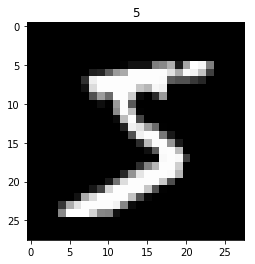

In [2]:
# Hyper Parameters
EPOCH=1  # 训练次数
BATCH_SIZE=50  # 每批训练的个数
LR=0.001  # 学习速率
DOWNLOAD_MNIST=False  # 是否下载MNIST数据
# 得到MNIST数据
train_data=torchvision.datasets.MNIST(
    root='./mnist',  # 下载到的文件夹
    train=True,  # 获取的是否是训练集数据,若为False则是获取测试集数据
    transform=torchvision.transforms.ToTensor(),  # 将下载的数据集转换为Tensor,其维度是[C,H,W]
    download=DOWNLOAD_MNIST
)
# 获取测试用的MNIST数据
test_data=torchvision.datasets.MNIST(root='./mnist/',train=False)

test_x=Variable(torch.unsqueeze(test_data.test_data,dim=1),volatile=True).type(torch.FloatTensor)[:2000]/255
test_y=test_data.test_labels[:2000]
# plot the MNIST
# print(train_data.train_data.size())
# print(train_data.train_labels.size())
# print(train_data.train_data[0])
plt.imshow(train_data.train_data[0].numpy(),cmap='gray')
plt.title('%i'%train_data.train_labels[0])
plt.show()

In [3]:
print(train_data)
print(type(train_data.train_data))
print(train_data.train_data.shape)  # 该数据集共60000张图片
print(train_data.train_data[3])  # 每一张图像的数据是一个28*28的ByteTensor
print(test_data)
print(test_data.test_data.shape)  # 测试集有10000张图片

<class 'torch.ByteTensor'>
torch.Size([60000, 28, 28])


Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0   

In [4]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(  # input shape (1,28,28)
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,  # 卷积核的大小5*5
                stride=1,  # 卷积的步长
                padding=2,  # 图像四周的填充
            ),  # output shape(16,28,28) 卷积层将高度为1的图像卷积成了高度16的图像
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(kernel_size=2),  # 池化层,最大法,其池化的核大小为2*2
        )  # output变为一16,14,14
        self.conv2=nn.Sequential(  # input shape (16,14,14)
            nn.Conv2d(16,32,5,1,2),  # 卷积层的参数的简化写法 output(32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2) # --->(32,7,7)
        )
        self.out=nn.Linear(32*7*7,10)  # 全连接层,进行线性分类
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)  #  展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output=self.out(x)
        return output

In [6]:
cnn=CNN()

In [7]:
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear(in_features=1568, out_features=10)
)

In [8]:
optimizer=torch.optim.Adam(cnn.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()

In [9]:
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x)
        b_y=Variable(y)
        
#         print(step)
        
        output=cnn(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if step%50==0:
            test_output=cnn(test_x)
            # 得到预测的结果
            pred_y=torch.max(test_output,1)[1].data.squeeze()  # max方法得到在dim=1上输入的Tensor的最大值
            accuracy=sum(pred_y==test_y)/test_y.size(0)  # sum()这里应该是算出测试结果与答案相等的数量
            print('Epoch',epoch,'|train loss:%.4f'%loss.data[0],'|test accuracy:',accuracy)

Epoch 0 |train loss:2.2999 |test accuracy: 0.15
Epoch 0 |train loss:0.3402 |test accuracy: 0.8255
Epoch 0 |train loss:0.3186 |test accuracy: 0.897
Epoch 0 |train loss:0.1971 |test accuracy: 0.9235
Epoch 0 |train loss:0.1576 |test accuracy: 0.945
Epoch 0 |train loss:0.0851 |test accuracy: 0.934
Epoch 0 |train loss:0.1416 |test accuracy: 0.959
Epoch 0 |train loss:0.0266 |test accuracy: 0.952
Epoch 0 |train loss:0.2082 |test accuracy: 0.9595
Epoch 0 |train loss:0.0884 |test accuracy: 0.963
Epoch 0 |train loss:0.1433 |test accuracy: 0.9655
Epoch 0 |train loss:0.1759 |test accuracy: 0.9665
Epoch 0 |train loss:0.0510 |test accuracy: 0.9705
Epoch 0 |train loss:0.1347 |test accuracy: 0.9685
Epoch 0 |train loss:0.0234 |test accuracy: 0.9705
Epoch 0 |train loss:0.0492 |test accuracy: 0.9675
Epoch 0 |train loss:0.0443 |test accuracy: 0.969
Epoch 0 |train loss:0.0629 |test accuracy: 0.9725
Epoch 0 |train loss:0.0055 |test accuracy: 0.977
Epoch 0 |train loss:0.0231 |test accuracy: 0.978
Epoch 0 |tr

In [10]:
# 利用测试集进行测试
test_output=cnn(test_x)
pred_y=torch.max(test_output,1)[1].data.numpy().squeeze()
print(pred_y,'prediction number')
print(test_y.numpy(),'real number')

[7 2 1 ... 3 9 5] prediction number
[7 2 1 ... 3 9 5] real number
